In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

## Load The Data

In [13]:
columns = ['Age', 'Sex', 'ChestPain', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [14]:
df_heart = pd.read_csv('heart.csv', names=columns, skiprows=1)

In [15]:
df_heart.head()

,Age,Sex,ChestPain,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [16]:
# Handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_heart[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']] = imputer.fit_transform(df_heart[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])


In [17]:
y = df_heart['HeartDisease']
X = df_heart.drop('HeartDisease', axis=1)
print(y.head())
print(X.head())

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64
    Age Sex ChestPain  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0  40.0   M       ATA      140.0        289.0          0     Normal  172.0   
1  49.0   F       NAP      160.0        180.0          0     Normal  156.0   
2  37.0   M       ATA      130.0        283.0          0         ST   98.0   
3  48.0   F       ASY      138.0        214.0          0     Normal  108.0   
4  54.0   M       NAP      150.0        195.0          0     Normal  122.0   

  ExerciseAngina  Oldpeak ST_Slope  
0              N      0.0       Up  
1              N      1.0     Flat  
2              N      0.0       Up  
3              Y      1.5     Flat  
4              N      0.0       Up  


### Encode Non Numerical Feature
Assigns numbers for features that are not originally numbers

In [18]:
# Encode categorical variables
encoder = OneHotEncoder()
X_encoded = pd.concat([pd.DataFrame(encoder.fit_transform(X[['Sex']]).toarray(), columns=['Female', 'Male']),
                       pd.DataFrame(encoder.fit_transform(X[['ChestPain']]).toarray(), columns=['ATA', 'ASY', 'NAP', 'TA']),
                       pd.DataFrame(encoder.fit_transform(X[['RestingECG']]).toarray(), columns=['LVH', 'Normal', 'ST']),
                       pd.DataFrame(encoder.fit_transform(X[['ExerciseAngina']]).toarray(), columns=['N', 'Y']),
                       pd.DataFrame(encoder.fit_transform(X[['ST_Slope']]).toarray(), columns=['Down', 'Flat', 'Up']),
                       X.drop(['Sex', 'ChestPain', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], axis=1)],
                       axis=1)

### Scale numerical features
Standardizes each feature by subtracting the mean and dividing by the standard deviation, resulting in a mean of 0 and a standard deviation of 1 for each feature

In [19]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]),
                        columns=['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'])


In [20]:
# Concatenate the encoded and scaled features
X_processed = pd.concat([X_encoded, X_scaled], axis=1)
X_processed.head()

,Female,Male,ATA,ASY,NAP,TA,LVH,Normal,ST,N,...,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,140.0,289.0,0,172.0,0.0,-1.433140,0.410909,0.825070,1.382928,-0.832432
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,160.0,180.0,0,156.0,1.0,-0.478484,1.491752,-0.171961,0.754157,0.105664
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,130.0,283.0,0,98.0,0.0,-1.751359,-0.129513,0.770188,-1.525138,-0.832432
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,138.0,214.0,0,108.0,1.5,-0.584556,0.302825,0.139040,-1.132156,0.574711
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,150.0,195.0,0,122.0,0.0,0.051881,0.951331,-0.034755,-0.581981,-0.832432


### Remove Outliers
Remove 10% of outliers from the data with an isolation forest.

In [21]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05)

outliers = iso_forest.fit_predict(X_processed)
X_filtered = X_processed[outliers == 1]
y_filtered = y[outliers == 1]

In [22]:
X_filtered.shape

(872, 25)

In [23]:
y_filtered.shape

(872,)

### Create the Train/Test split

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)



In [25]:
print(X_train.shape)
print(X_test.shape)

(697, 25)
(175, 25)


In [26]:
print(y_train.shape)
print(y_test.shape)

(697,)
(175,)


## SVM Classification

In [27]:
svm_model = SVC()
svm_model.fit(X_train, y_train)


SVC()

In [28]:
y_pred_svc = svm_model.predict(X_test)

# Evaluate the model
accuracy_score(y_test, y_pred_svc)

0.7085714285714285

## Decision Tree Classification

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [30]:
y_pred_dt = dt.predict(X_test)
accuracy_score(y_test, y_pred_dt)

0.8285714285714286

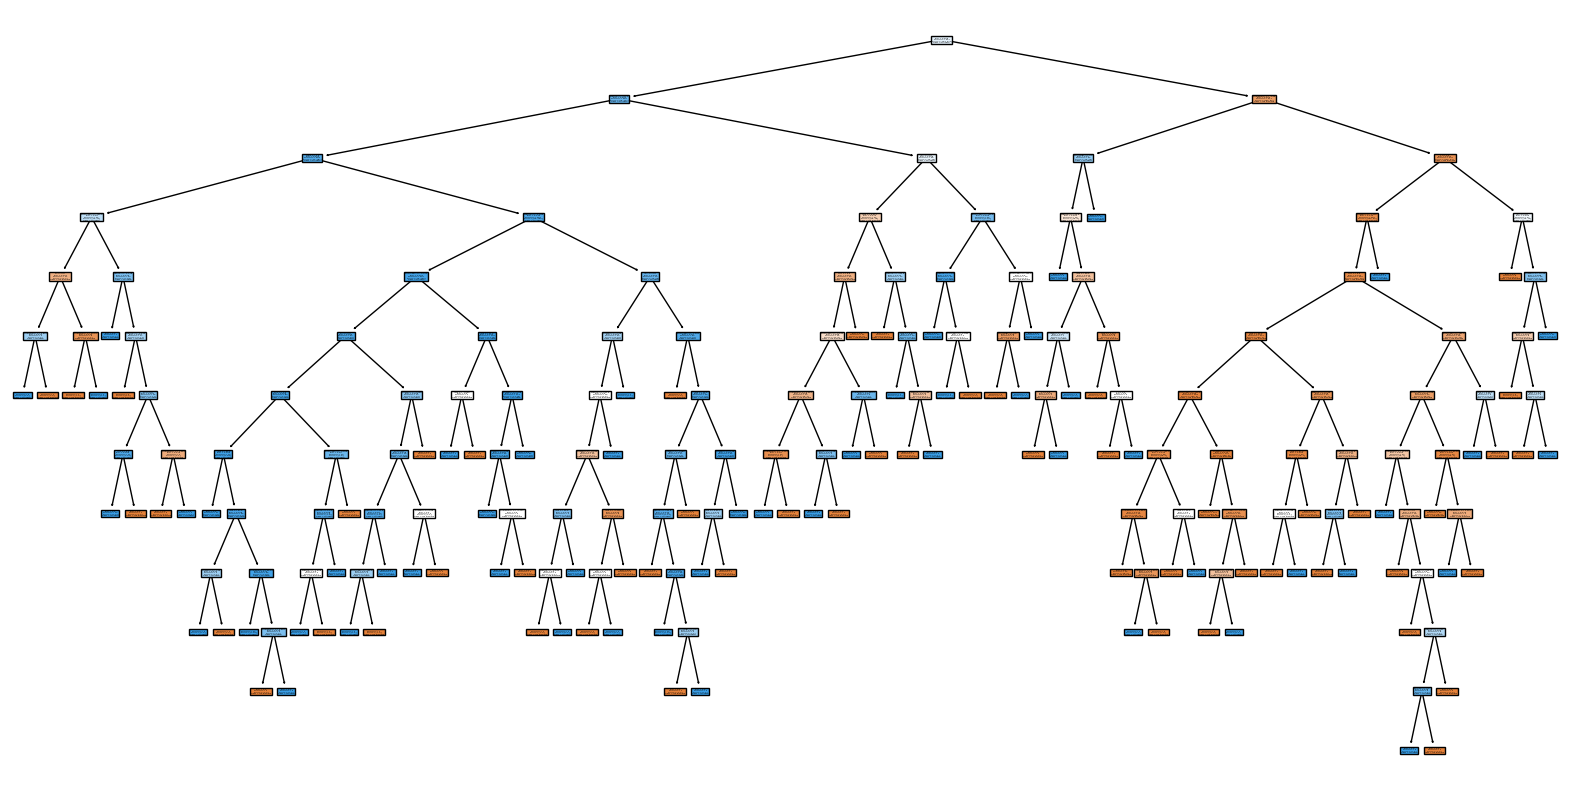

In [31]:
# Display the decision tree
feat_names = X_train.columns.tolist()
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=feat_names, class_names=['No Disease', 'Disease'])
plt.show()

In [32]:
dt.tree_.node_count

211

## Neural Network Classification

In [33]:
import tensorflow as tf
from tensorflow import keras 

ImportError: cannot import name 'enum_type_wrapper' from 'google.protobuf.internal' (unknown location)

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(25,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()